In [64]:
import h5py    
import numpy as np    
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time
sb.set(rc = {'figure.figsize':(50,38)})
sb.set(font_scale=3)
features = pd.read_csv('deepsea_beluga_2002_features.tsv.txt', sep = '\t')


In [80]:
files = [f for f in os.listdir('.') if '.h5' in f]
filtered_files = []
date_thres = '01/05/2022'
for fil in files:
    modificationTime = time.strftime('%d/%m/%Y', time.localtime(os.path.getmtime(fil)))
    if pd.to_datetime(modificationTime) >= pd.to_datetime(date_thres):
        filtered_files.append(fil)
        print(fil)
        print(modificationTime)



rs10119.diff.h5
01/05/2022
rs10414043.diff.h5
01/05/2022
rs111789331.diff.h5
22/04/2022
rs11556505.diff.h5
01/05/2022
rs12721046.diff.h5
01/05/2022
rs12721051.diff.h5
01/05/2022
rs12972156.diff.h5
01/05/2022
rs12972970.diff.h5
01/05/2022
rs157581.diff.h5
22/04/2022
rs157582.diff.h5
01/05/2022
rs184017.diff.h5
01/05/2022
rs2075650.diff.h5
22/04/2022
rs283811.diff.h5
01/05/2022
rs283815.diff.h5
22/04/2022
rs34095326.diff.h5
22/04/2022
rs34342646.diff.h5
01/05/2022
rs34404554.diff.h5
25/03/2022
rs41377151.diff.h5
01/05/2022
rs429358.diff.h5
01/05/2022
rs483082.diff.h5
01/05/2022
rs5117.diff.h5
01/05/2022
rs56131196.diff.h5
01/05/2022
rs59007384.diff.h5
25/03/2022
rs66626994.diff.h5
25/03/2022
rs6857.diff.h5
25/03/2022
rs71352238.diff.h5
25/03/2022
rs7256200.diff.h5
25/03/2022
rs75627662.diff.h5
01/05/2022
rs769449.diff.h5
01/05/2022


In [81]:
def group_check(snp_feature_list,snp_comb_name_list):
    snp_groups_bool = []
    for k in snp_comb_name_list:
        snp_groups_bool.append('_' not in k)
    snp_groups_bool = sum(([ss]*2 for ss in snp_groups_bool),[])
    group1 = snp_feature_list[snp_groups_bool]
    group1_overall = np.max(group1,axis=0)
    
    group2_idxs = [not idx for idx in snp_groups_bool]
    group2 = snp_feature_list[group2_idxs]
    group2_sub = np.subtract(group1_overall,group2)
    group2_ratio = np.divide(group2,group1_overall)
    #group2_sub = np.log(group2_sub)
    return group1_overall,group2_sub,group2_ratio,group2_idxs


def correlation_check(snp_feature_list, snp_comb_name_list):
    
    filtered_combs = []
    for snp1 in range(0,len(snp_feature_list)):
        for snp2 in range(0,len(snp_feature_list)):
            corr,_ = pearsonr(snp_feature_list[snp1],snp_feature_list[snp2])
            if -0.5 <= corr <= 0.5:
                filtered_combs.append(snp1)
                filtered_combs.append(snp2)
    filtered_combs = list(set(filtered_combs))            
    return filtered_combs

In [ ]:
comb_dict = {}
comb_arrays = {}

for ij in range(0,len(filtered_files)):
    f = h5py.File(filtered_files[ij],'r+')  
    combs_keys = list(f.keys())
    snp_list = np.zeros((len(combs_keys)*2,2002))
    for i in range(0,2*len(combs_keys),2):
        snp_list[i,:] = f[combs_keys[int(i/2)]][()][0,:]
        snp_list[i+1,:] = f[combs_keys[int(i/2)]][()][0,:]
    t_name = files[ij].split('.diff.h5')[0]

    #Method 1
    filt_list = correlation_check(snp_list,combs_keys)    
    #Method 2
    _,met2_sub,met2_ratio,idd = group_check(snp_list,combs_keys)    
    
    ii = np.where(_ == np.max(_))[0][0]
    ij = np.where(met2_sub == np.max(met2_sub))[0]
    if len(ij) > 1:
        ij = np.where(met2_sub == np.max(met2_sub))[1][0]
    else:
        ij = np.where(met2_sub == np.max(met2_sub))[0][0]
    jj = np.where(_ == np.min(_))[0][0]
    ji = np.where(met2_sub == np.min(met2_sub))[0]
    if len(ji) > 1:
        ji = np.where(met2_sub == np.min(met2_sub))[1][0]
    else:
        ji = np.where(met2_sub == np.min(met2_sub))[0][0]
    comb_dict[t_name] = [np.max(_),met2_sub[:,ii], np.max(met2_sub),_[ij],
                         np.min(_),met2_sub[:,jj],np.min(met2_sub),_[ji]]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-81-a5867e31ff06>:12: RuntimeWarning: divide by zero encountered in true_divide
  group2_ratio = np.divide(group2,group1_overall)


In [ ]:
pd.DataFrame.from_dict(comb_dict, orient = "index", columns= ['Group 1 Max',"Group 2 @ Group1 max index",
                                                              "Group 2 Max","Group 1 @ Group2 max index",
                                                              "Group 1 Min","Group 2 @ Group1 min index",
                                                              "Group 2 Min","Group 1 @ Group2 min index"])


The number of significant ld snps for rs10119 are 32
The number of combinations from method 2 for rs10119 is 2


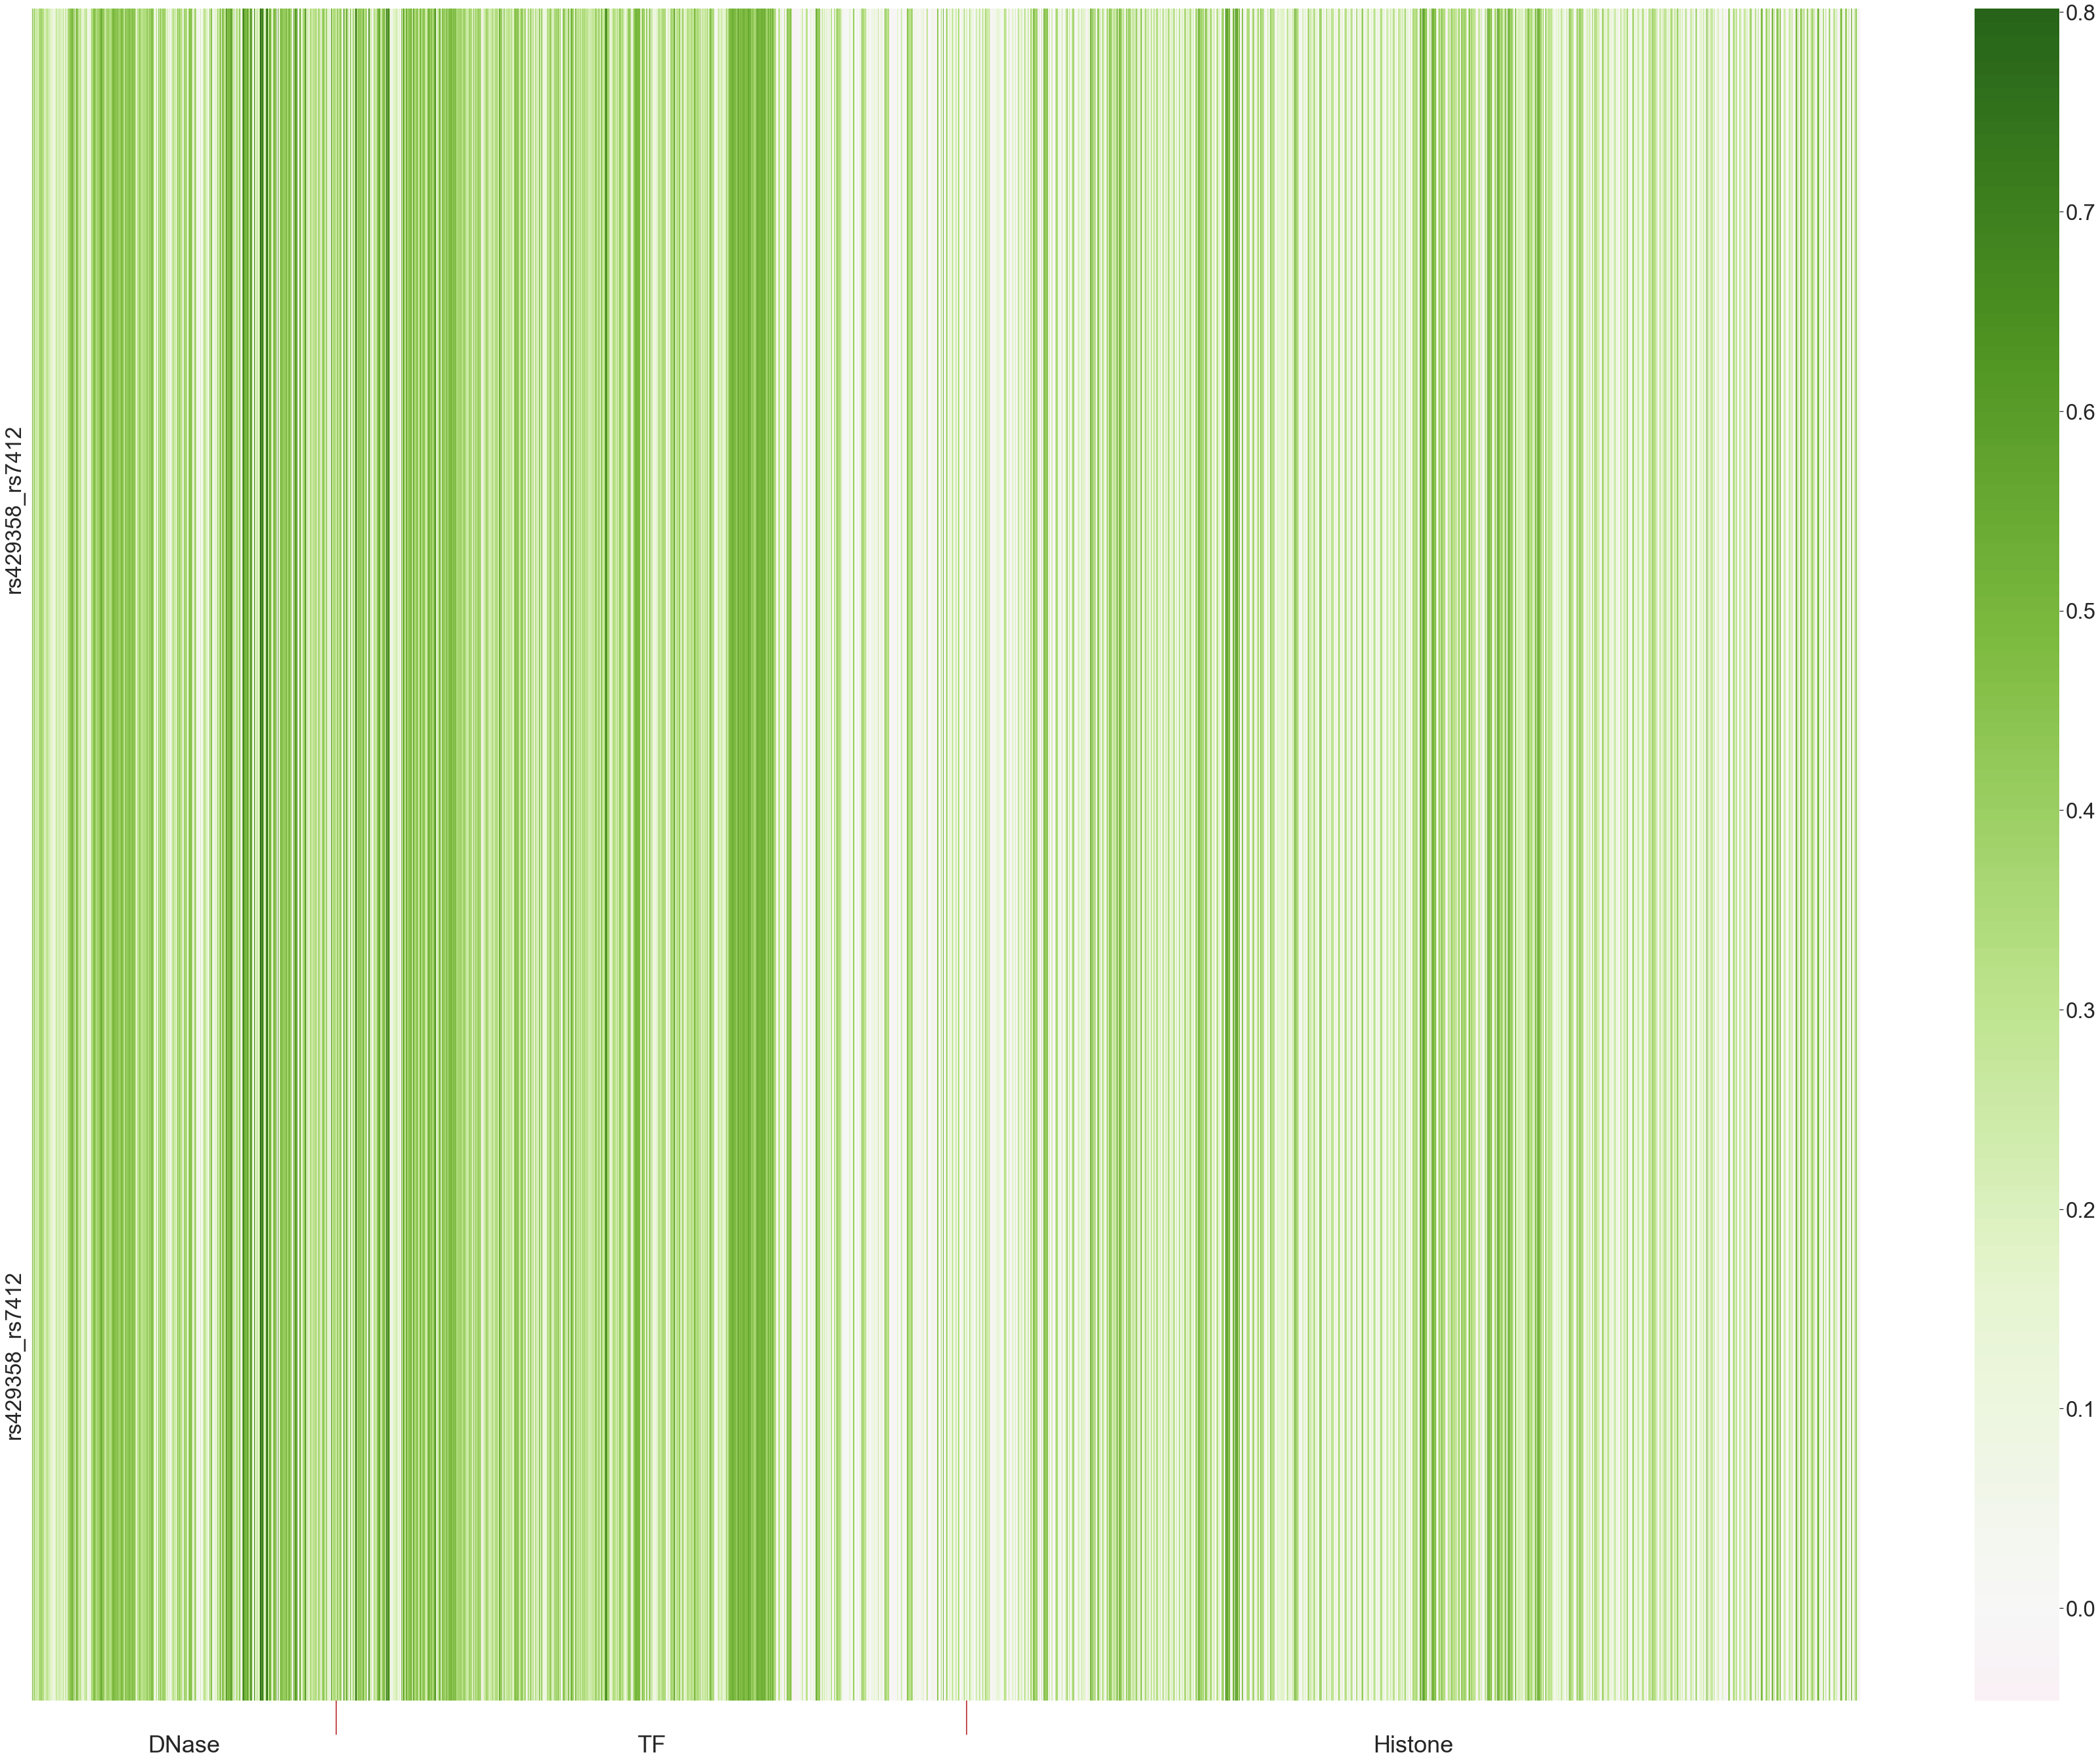

<Figure size 3600x2736 with 0 Axes>

In [5]:
comb_dict = {}
comb_arrays = {}
for ij in range(0,len(filtered_files)):
    f = h5py.File(filtered_files[ij],'r+')  
    combs_keys = list(f.keys())
    snp_list = np.zeros((len(combs_keys)*2,2002))
    for i in range(0,2*len(combs_keys),2):
        snp_list[i,:] = f[combs_keys[int(i/2)]][()][0,:]
        snp_list[i+1,:] = f[combs_keys[int(i/2)]][()][0,:]
    t_name = files[ij].split('.diff.h5')[0]

    #Method 1
    filt_list = correlation_check(snp_list,combs_keys)    
    #Method 2
    _,met2_sub,met2_ratio,idd = group_check(snp_list,combs_keys)    
    
    print("The number of significant ld snps for %s are %d" %(t_name,len(filt_list)))
    comb_dict[t_name] = [len(filt_list),len(set(filt_list))]

    comb_arrays[t_name] = met2_sub
    print("The number of combinations from method 2 for %s is %d" %(t_name,len(met2_sub)))
    
    
    xticklabels = features['Assay type']
    labels = xticklabels.unique()
    label_lens = [len([k for k in xticklabels if 'DNase' in k]),len([k for k in xticklabels if 'TF' in k]),len([k for k in xticklabels if 'Histone' in k])]

    xlabs = list(f.keys())
    xlabs = [[x]*2 for x in xlabs]
    xlabs =  [item for sublist in xlabs for item in sublist]
    prob_matrix = pd.DataFrame(snp_list)
    
    iddx = [idd[i] for i in range(0,len(idd),2)]
    xlabels = [combs_keys[i] for i in range(0,len(iddx)) if iddx[i]]
    xlabels = sum(([ss]*2 for ss in xlabels),[])
    if len(xlabels) != 0:
        ax = sb.heatmap(met2_sub,yticklabels = xlabels,xticklabels=[], center=0, cmap = 'PiYG')
        pos = 0
        for label, label_len in zip(labels, label_lens):
            if pos != 0:
                ax.vlines(pos, 0, -0.02, color='r', lw=2,transform=ax.get_xaxis_transform(), clip_on=False)
            ax.text(pos + label_len / 2, -0.02, label, ha='center', va='top',transform=ax.get_xaxis_transform())
            pos += label_len
        plt.tight_layout()
        #plt.savefig('.'.join([files[ij].split('.diff.h5')[0],'png']))
        plt.show()
        plt.clf()

In [68]:
comb_dict = {}
comb_arrays = {}
f = h5py.File('rs429358.diff.h5','r+')  
combs_keys = list(f.keys())
snp_list = np.zeros((len(combs_keys)*2,2002))
for i in range(0,2*len(combs_keys),2):
    snp_list[i,:] = f[combs_keys[int(i/2)]][()][0,:]
    snp_list[i+1,:] = f[combs_keys[int(i/2)]][()][0,:]
t_name = 'rs429358.diff.h5'.split('.diff.h5')[0]

    #Method 1
filt_list = correlation_check(snp_list,combs_keys)    
    #Method 2
_,met2_sub,met2_ratio,idd = group_check(snp_list,combs_keys)    
    
print("The number of significant ld snps for %s are %d" %(t_name,len(filt_list)))
comb_dict[t_name] = [len(filt_list),len(set(filt_list))]

comb_arrays[t_name] = met2_sub
print("The number of combinations from method 2 for %s is %d" %(t_name,len(met2_sub)))
    




The number of significant ld snps for rs429358 are 32
The number of combinations from method 2 for rs429358 is 2


In [76]:
snp_list

array([[-0.10951018, -0.4864049 , -0.06112695, ...,  0.14123583,
        -0.04105568,  0.1573782 ],
       [-0.10951018, -0.4864049 , -0.06112695, ...,  0.14123583,
        -0.04105568,  0.1573782 ],
       [-0.10325766, -0.45252609, -0.06699061, ...,  0.14212108,
        -0.02280998,  0.17390537],
       [-0.10325766, -0.45252609, -0.06699061, ...,  0.14212108,
        -0.02280998,  0.17390537],
       [ 0.00776672,  0.03720379, -0.00568628, ...,  0.00202417,
         0.02077007,  0.01934433],
       [ 0.00776672,  0.03720379, -0.00568628, ...,  0.00202417,
         0.02077007,  0.01934433]])

In [69]:
# Categorizing the heatmap values 
symbol_annot =np.chararray(met2_sub.shape,itemsize=2)
symbol_annot[:] = ''
met2_ratio_cat = met2_sub
for Rr in range(0,met2_ratio.shape[0]):
    for Cc in range(0,met2_ratio.shape[1]):
        
        if -0.1 < met2_sub[Rr,Cc] < 0.1:
            met2_ratio_cat[Rr,Cc] = 0
        elif -0.5 < met2_sub[Rr,Cc] > 0.5:
            symbol_annot[Rr,Cc] = 'XX'
        elif -0.25 < met2_sub[Rr,Cc] > 0.25:
            symbol_annot[Rr,Cc] = 'X'
        elif met2_sub[Rr,Cc] == 'Inf':
            symbol_annot[Rr,Cc] = 'O'

        
        


In [71]:
symbol_annot = pd.DataFrame(symbol_annot)
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

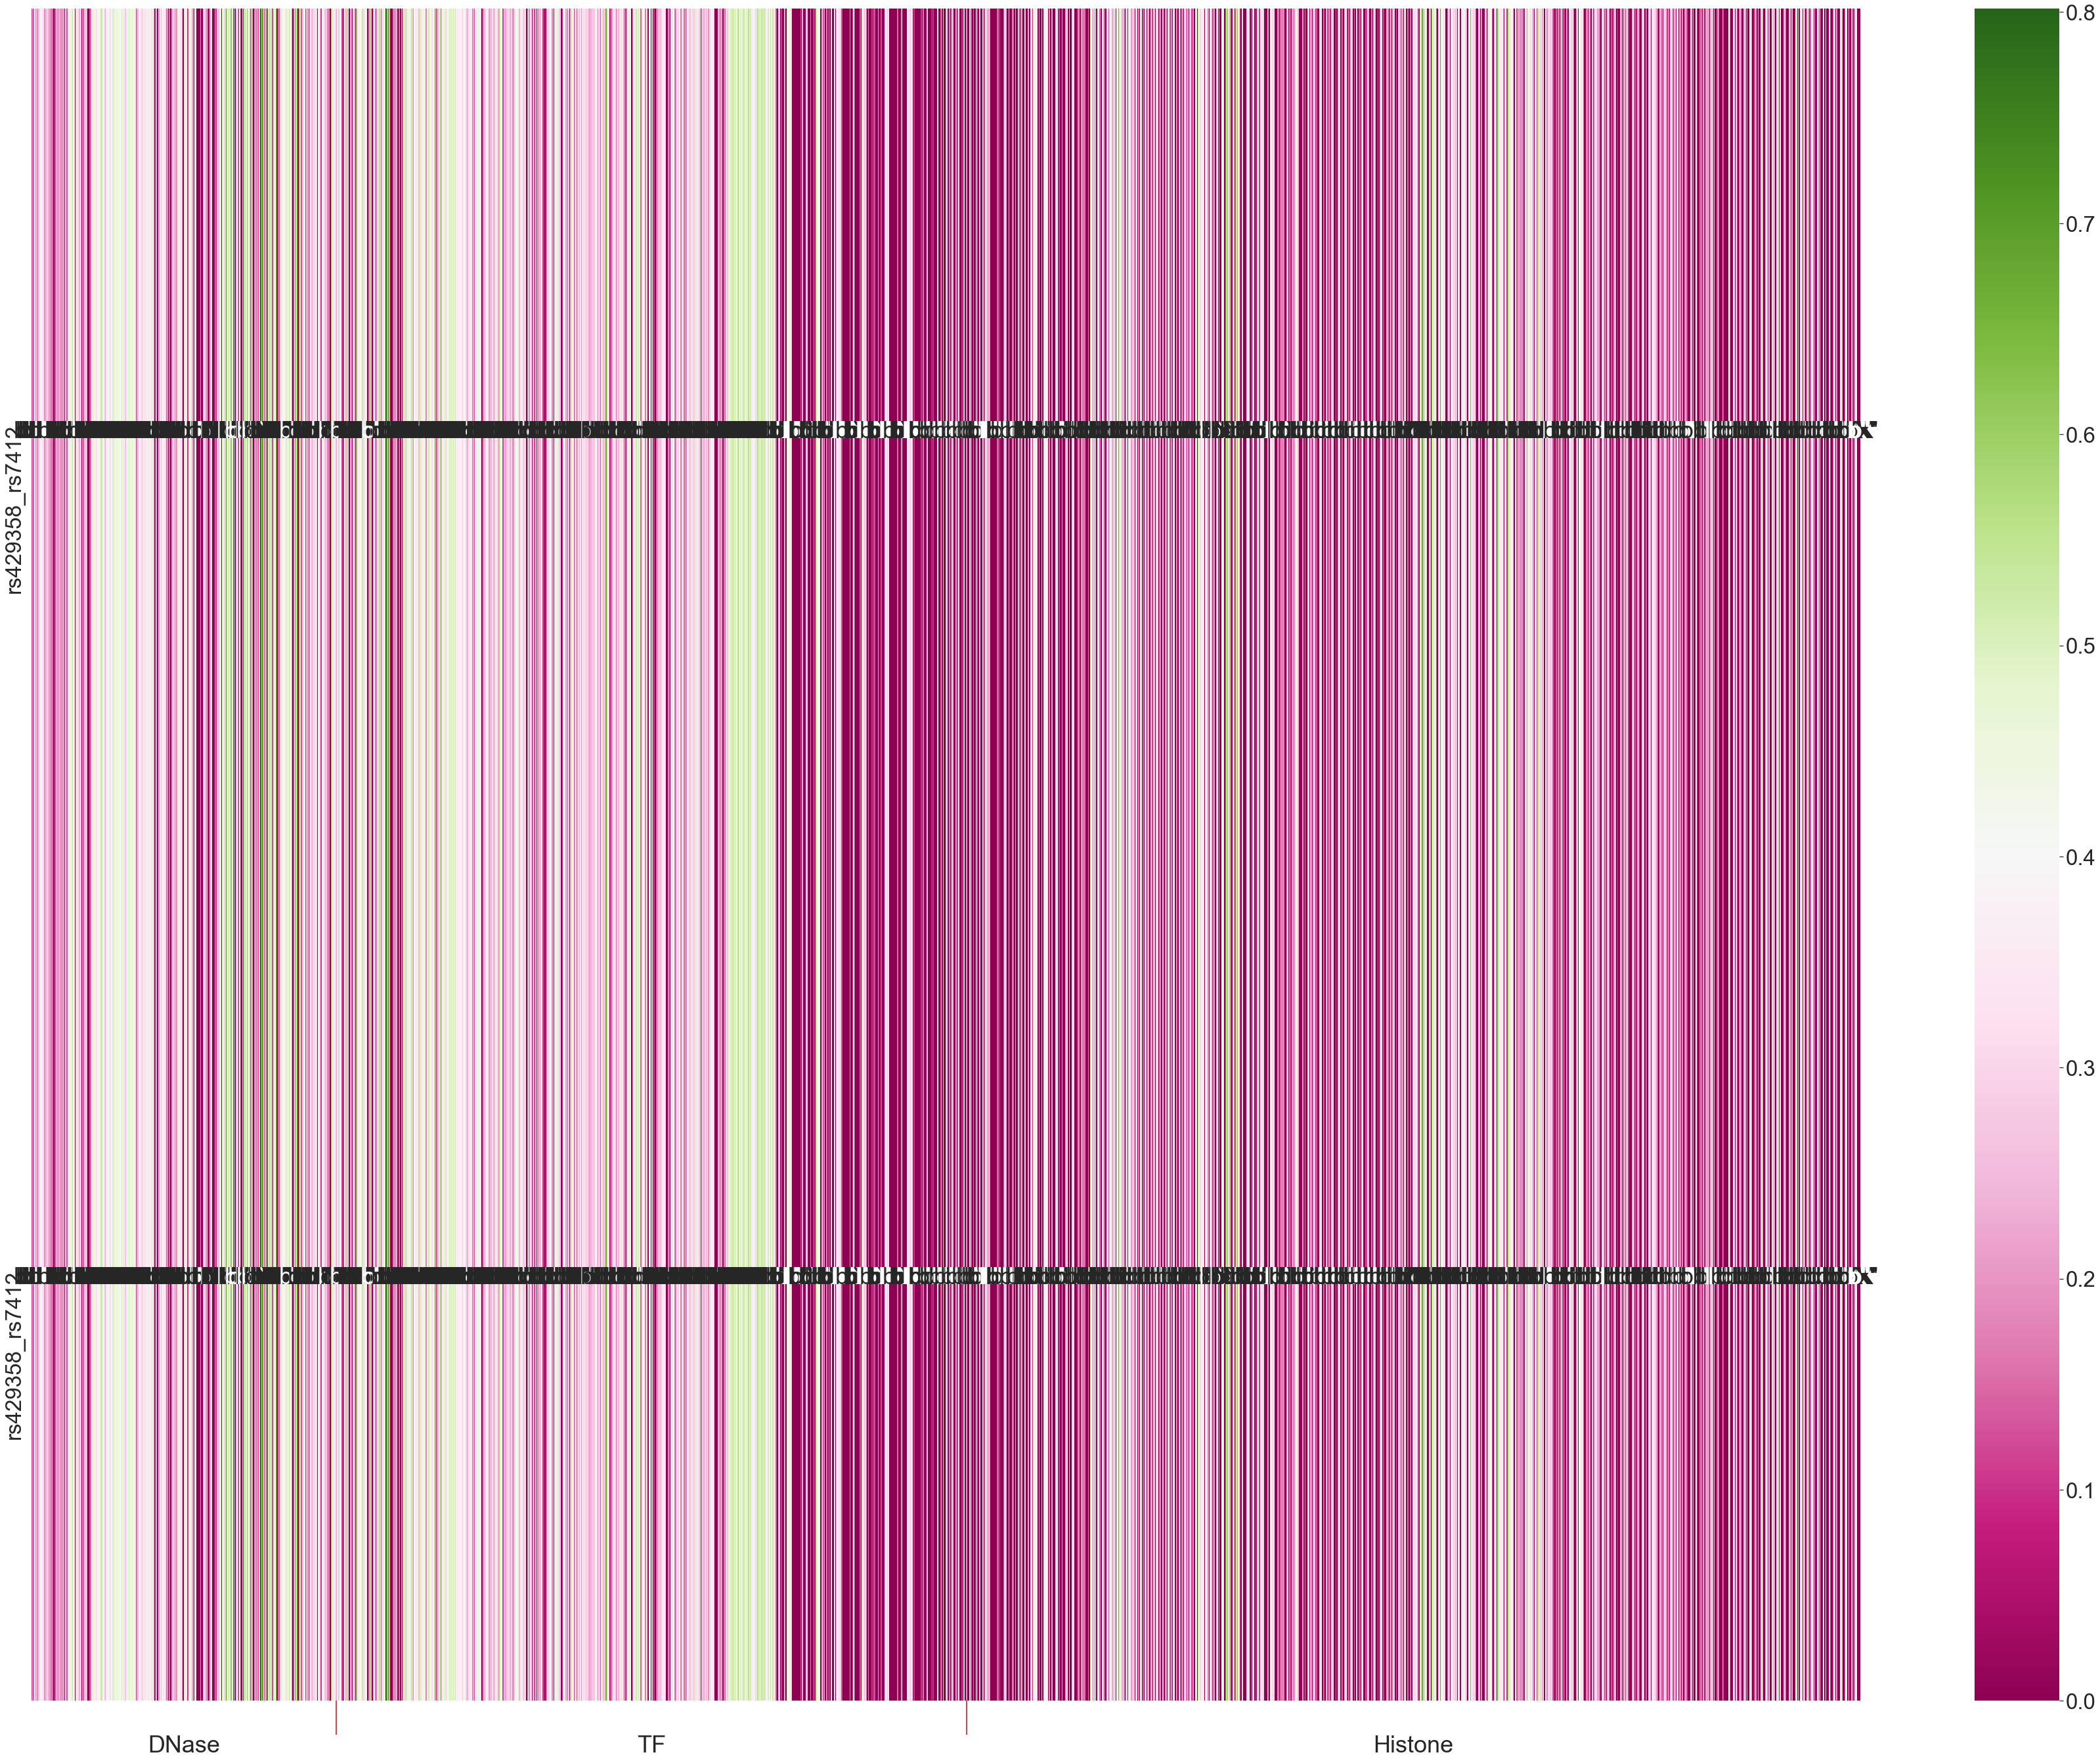

In [72]:
xticklabels = features['Assay type']
labels = xticklabels.unique()
label_lens = [len([k for k in xticklabels if 'DNase' in k]),len([k for k in xticklabels if 'TF' in k]),len([k for k in xticklabels if 'Histone' in k])]

xlabs = list(f.keys())
xlabs = [[x]*2 for x in xlabs]
xlabs =  [item for sublist in xlabs for item in sublist]
prob_matrix = pd.DataFrame(snp_list)
annot_kws = {"ha": 'left',"va": 'top'}
iddx = [idd[i] for i in range(0,len(idd),2)]
xlabels = [combs_keys[i] for i in range(0,len(iddx)) if iddx[i]]
xlabels = sum(([ss]*2 for ss in xlabels),[])
if len(xlabels) != 0:
    ax = sb.heatmap(met2_sub,yticklabels = xlabels,xticklabels=[], 
                    cmap = 'BuGn',annot = symbol_annot,annot_kws= annot_kws,fmt='')

    pos = 0
    for label, label_len in zip(labels, label_lens):
        if pos != 0:
            ax.vlines(pos, 0, -0.02, color='r', lw=2,transform=ax.get_xaxis_transform(), clip_on=False)
        ax.text(pos + label_len / 2, -0.02, label, ha='center', va='top',transform=ax.get_xaxis_transform())
        pos += label_len
    plt.tight_layout()
    plt.savefig('test.png')
